In [1]:
!git clone https://github.com/Hen0k/causal-inference.git
%cd "causal-inference/notebooks"

Cloning into 'causal-inference'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 110 (delta 35), reused 90 (delta 22), pack-reused 0
Receiving objects: 100% (110/110), 10.77 MiB | 36.41 MiB/s, done.
Resolving deltas: 100% (35/35), done.
/content/causal-inference/notebooks


In [2]:
!apt-get install graphviz graphviz-dev -q
!pip install pygraphviz -q
!pip install causalnex -q

Reading package lists...
Building dependency tree...
Reading state information...
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 49 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24.32-1ubuntu1 [1,769 kB]
Get:3 http://

In [3]:
import sys
sys.path.append("../scripts/")

from IPython.display import Image

import warnings
from causalnex.structure.notears import from_pandas
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

warnings.filterwarnings("ignore")  # silence warnings

# custom modules import
from utils import DataLoader



# Learning the Structure

As the number of variables grows, or when domain knowledge does not exist, it can be tedious to define a structure manually. We can use CausalNex to learn the structure model from data. The structure learning algorithm we are going to use here is the NOTEARS algorithm.

When learning structure, we can use the entire dataset. Since structure should be considered as a joint effort between machine learning and domain experts, it is not always necessary to use a train / test split.

But before we begin, we have to pre-process the data so that the NOTEARS algorithm can be used.

In [6]:
loader = DataLoader("../data", "data.csv")
struct_data = loader.read_csv()
cols_to_keep = [
    'diagnosis',
    'radius_worst',
    'concave points_mean',
    'concave points_worst',
    'perimeter_worst',
    'area_mean',
    'area_worst',
    'radius_mean',
    'perimeter_mean',
]
struct_data = struct_data[cols_to_keep]


In [7]:
from visualization import Plotters
plotters = Plotters(w=10, h=10)


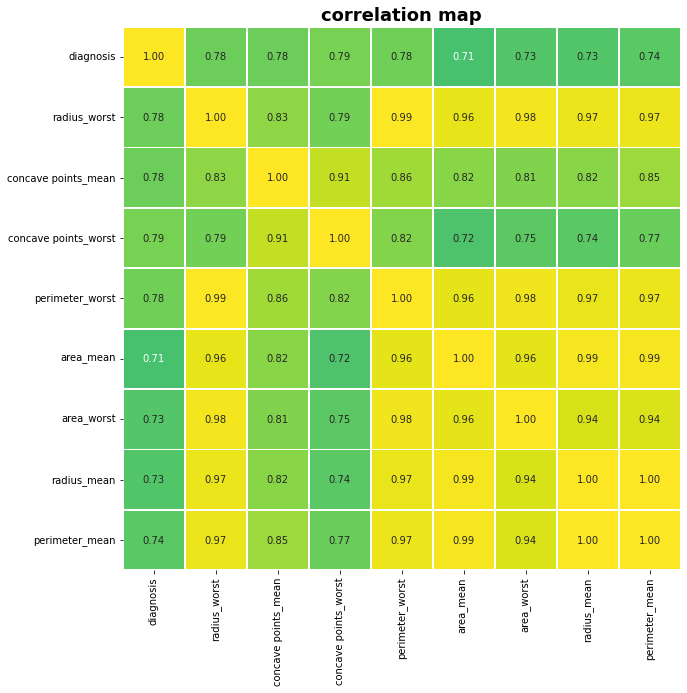

In [8]:
plotters.plot_heatmap(struct_data.corr(), "correlation map")

In [9]:
sm = from_pandas(struct_data)

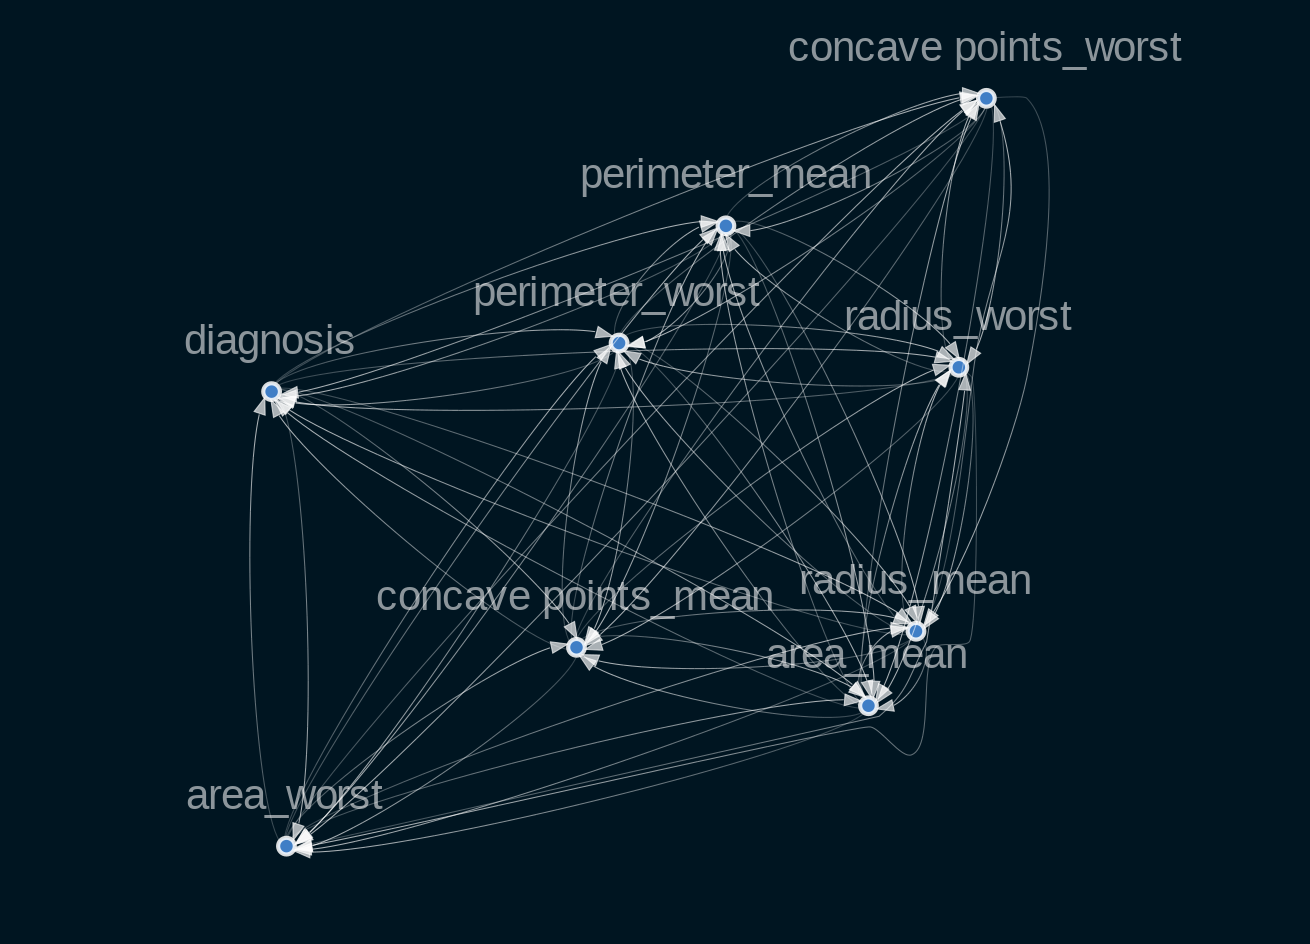

In [19]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
    prog='fdp',
)
Image(viz.draw(format='png'))

In [25]:
import networkx as nx

nx.drawing.nx_pydot.write_dot(sm, '../../graph.dot')

In [41]:
sm = from_pandas(struct_data, w_threshold=0.3)

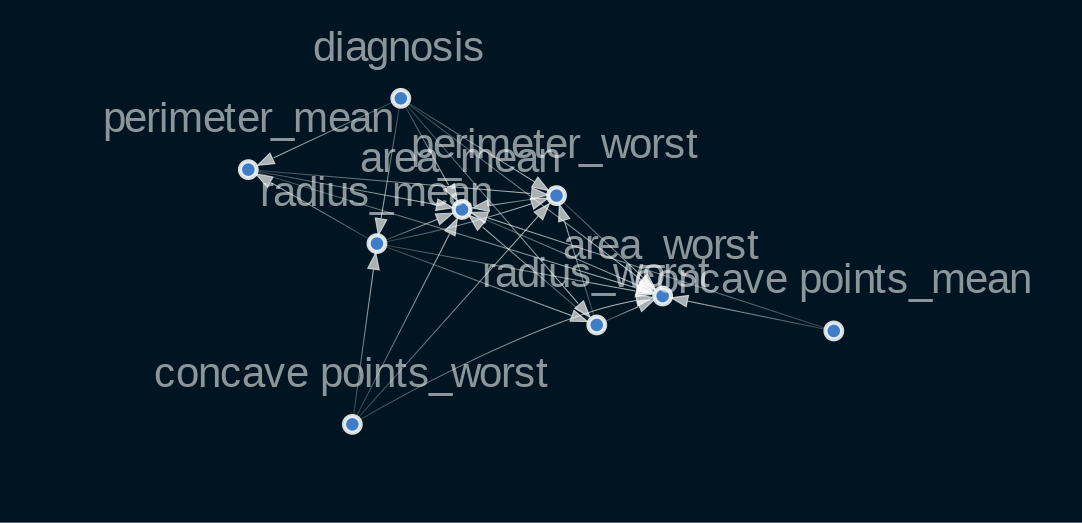

In [42]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
    prog='fdp',
)
Image(viz.draw(format='png'))

In [43]:
from causalnex.network import BayesianNetwork
# sm = sm.get_largest_subgraph()
bn = BayesianNetwork(sm)

In [44]:
nx.drawing.nx_pydot.write_dot(sm, '../../acyclyc_graph.dot')